## Домашнее задание Numpy Neural Net Exploration (50 баллов)

В этом домашнем задании требуется провести набор экспериментов с нейронной сетью. Для проведения экспериментов нужно доработать представленный фреймворк для обучения нейронной сети на Numpy в проекте **Numpy_NN** c **hinge_loss** функцией ошибки. 

Ссылка на проект - https://github.com/runnerup96/Numpy-NN-Framework

Все необходимые доработки обозначены в проекте тегом **TODO**.

В ноутбуке только сами эксперименты с помощью данных команд - все доработки делать внутри фреймворка.

In [1]:
import os
import sys
import glob
import pickle
import numpy as np
import importlib
from sklearn.metrics import classification_report

sys.path.append(os.path.join(os.getcwd(), "src"))

from dataset.dataloader import Dataloader
from utils import gradient_check
from dataset import dataloader
from nn.module.sequential import Sequential
from nn.layers.linear import Linear
from nn.layers.batch_norm import BatchNorm
from nn.layers.dropout import Dropout
from nn.activations.relu import ReLU
from nn.activations.sigmoid import Sigmoid
from nn.activations.tanh import Tanh
from optimization.adam_optimizer import Adam
from optimization.gd_optimizer import GD
from nn import loss_functions
from training.train import train
import visualization_utils as viz_utils

importlib.reload(dataloader)
from nn.loss_functions.hinge_loss import hinge_loss
sys.path.append(os.path.join(os.getcwd(), "src"))

from nn.module import sequential

# пример быстрой перезагрузки модуля без рестарта ноутбука
import importlib
importlib.reload(sequential)

<module 'nn.module.sequential' from '/home/anna/Desktop/Numpy-NN-Framework/src/nn/module/sequential.py'>

Вам нужно провести набор экспериментов с CIFAR датасетом и исследовать поведение нейронной сети на этом датасете при разных архитектурах. Пример 1ого эксперимента можно найти в ноутбуке **test_CIFAR_training.py**

Ваши эксперименты должы быть логичны - старайтесь последовательно строить архитектуру и попытайтесь к концу эксприментов определить комбинацию компонент нейронной сети для лучшего качества. Также же вы можете расширять количеcтво экспериментов, подтверждая это соответсвующими выводами. 

В каждом эксперименте должен быть:
    
    * Процесс обучения нейронной сети с помощью training.train.train
    * Проверка градиента для каждой архитектуры нейронной сети с помощью utils.gradient_check(если это указано в описании эксперимента)
    * Визуализация обучения - воспользоваться методом visualization_utils.plot_learning_curves
    * Рассчет точности общей точности модели и рассчет по классовой точности с помощью sklearn.metrics.classification_report
    * Ваш вывод по результату эксперимента
    
В каждом эксперименте должен быть каждый пункт иначе эксперимент не оценивается. Каждый эксперимент оценивается в **4 балла**. За расширение пространства экспериментов и реализации своих идей можно дополнительно получить до **6 баллов**.

В данном ДЗ оценивается качество работы доработанного вами фреймворка, качество проведения эксперимента и полученный результат.

## Данные
Скачаем, распакуем и проведем предобработку датасета CIFAR

In [2]:
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

--2023-02-28 18:25:49--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  5.92MB/s    in 29s     

2023-02-28 18:26:20 (5.57 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]



In [3]:
!tar -xzf cifar-10-python.tar.gz

In [2]:
with open("cifar-10-batches-py/data_batch_1", "rb") as f:
    train_dataset_1 = pickle.load(f, encoding="bytes")

with open("cifar-10-batches-py/data_batch_2", "rb") as f:
    train_dataset_2 = pickle.load(f, encoding="bytes")

with open("cifar-10-batches-py/data_batch_3", "rb") as f:
    train_dataset_3 = pickle.load(f, encoding="bytes")

with open("cifar-10-batches-py/data_batch_4", "rb") as f:
    train_dataset_4 = pickle.load(f, encoding="bytes")

with open("cifar-10-batches-py/data_batch_5", "rb") as f:
    train_dataset_5 = pickle.load(f, encoding="bytes")

In [3]:
print(f"Количество данных: {len(train_dataset_1[b'data'])}")
print(f"Размер вектора: {train_dataset_1[b'data'][0].shape}")

Количество данных: 10000
Размер вектора: (3072,)


Соберем все вместе и разделим на трейн и вал. На валидационную выборку оставим 10000 элементов, по 1000 примеров из каждого класса, выбранных случайно

In [4]:
datasets = [train_dataset_1, train_dataset_2, train_dataset_3,
            train_dataset_4, train_dataset_5]

train_dataset = []

for dataset in datasets:
    for vec, label in zip(dataset[b'data'], dataset[b'labels']):
        train_dataset.append((vec / 256, label))

In [5]:
np.random.seed(42)
np.random.shuffle(train_dataset)

train_data = []
valid_data = []

cnt = {ind: 0 for ind in range(10)}

for vec, label in train_dataset:
    if cnt[label] < 1000:
        cnt[label] += 1
        valid_data.append((vec, label))
    else:
        train_data.append((vec, label))

In [6]:
# тестовый датасет

with open("cifar-10-batches-py/test_batch", "rb") as f:
    test_dataset = pickle.load(f, encoding="bytes")

test_data = []
for vec, label in zip(test_dataset[b'data'], test_dataset[b'labels']):
    test_data.append((vec / 256, label))

In [7]:
# отнормируем все данные

train_matrix = np.array([item[0] for item in train_data])
D = np.var(train_matrix, axis=0)
E = np.mean(train_matrix, axis=0)

for ind in range(len(train_data)):
    train_data[ind] = (train_data[ind][0] - E, train_data[ind][1])
    train_data[ind] = (train_data[ind][0] / np.sqrt(D), train_data[ind][1])

for ind in range(len(valid_data)):
    valid_data[ind] = (valid_data[ind][0] - E, valid_data[ind][1])
    valid_data[ind] = (valid_data[ind][0] / np.sqrt(D), valid_data[ind][1])

for ind in range(len(test_data)):
    test_data[ind] = (test_data[ind][0] - E, test_data[ind][1])
    test_data[ind] = (test_data[ind][0] / np.sqrt(D), test_data[ind][1])

In [8]:
train_data[0][0].shape

(3072,)

## Функции для проведения экспериментов

In [9]:
def experiment(train_data, valid_data, model,
               epochs, lr, optim="Adam", batch_size=100,
               eps=1e-3, alpha1=None, alpha2=None):

    # train model
    print("\n Обучение модели\n")
    train_loss_history, valid_loss_history, \
    train_acc_history, valid_acc_history = train(
        dataset=train_data,
        model=model,
        epochs=epochs,
        lr=lr,
        valid_dataset=valid_data,
        batch_size=batch_size,
        optim_method=optim,
        alpha1=alpha1,
        alpha2=alpha2,
    )

    print("\n Визуализация обучения\n")
    viz_utils.plot_learning_curves(
        train_loss_history, valid_loss_history,
        train_acc_history, valid_acc_history
    )

    print("\n Проверка качества\n")
    test_dataloader = Dataloader(test_data, 100, False)
    model.eval()
    counter = 0
    test_loss = 0
    test_acc = 0
    for vecs, labels in test_dataloader:
        counter += 1
        out = model.forward(vecs)

        loss = hinge_loss(out, labels)
        test_loss += loss.item()

        pred_labels = np.argmax(out.array, axis=-1)
        test_acc += np.sum(pred_labels == labels) / len(labels)
    test_loss /= counter
    test_acc /= counter

    print(f"Ошибка на тесте: {test_loss:.4f}")
    print(f"Точность на тесте: {test_acc:.4f}")

    print("\n")
    print(classification_report(labels, pred_labels))

### Эксперимент 1 Построение нейронной сети с ReLU функцией активации

Реализуйте эксперимент, доработав соответсвующие модули Numpy_NN фреймворка. Количество слоев, функций на ваше усмотрение. Можно добавлять любые другие функции активации на ваше усмотрение, но указанная в эксперименте функция должна быть обязательно. Перед обучением проверьте с помощью utils.gradient_check градиент вашей модели.

In [10]:
np.random.seed(42)

model = Sequential(
    Linear(3072, 768),
    ReLU(),
    Linear(768, 10)
)

In [11]:
dataloader = Dataloader(train_data, batch_size=8)
x, y = next(iter(dataloader))
gradient_check(x, y, model)

1.9202864369675332 1.92
Backprop is correct!


2.622625003312464e-13


 Обучение модели

|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
|  1/5|  4.9103  | 0.4084  |  5.5398  | 0.3838  | 0.005538 |   79.0   |   79.0   |  
|  2/5|  3.2001  | 0.4956  |  3.9891  | 0.4453  | 0.003898 |   73.5   |  152.5   |  
|  3/5|  5.0047  | 0.4979  |  4.2038  | 0.4357  | 0.005783 |   71.5   |  223.9   |  
|  4/5|  2.4593  | 0.5362  |  4.0814  | 0.4567  | 0.004457 |   72.0   |  295.9   |  
|  5/5|  2.9321  | 0.5577  |  3.8534  | 0.4738  | 0.003569 |   70.4   |  366.3   |  

 Визуализация обучения



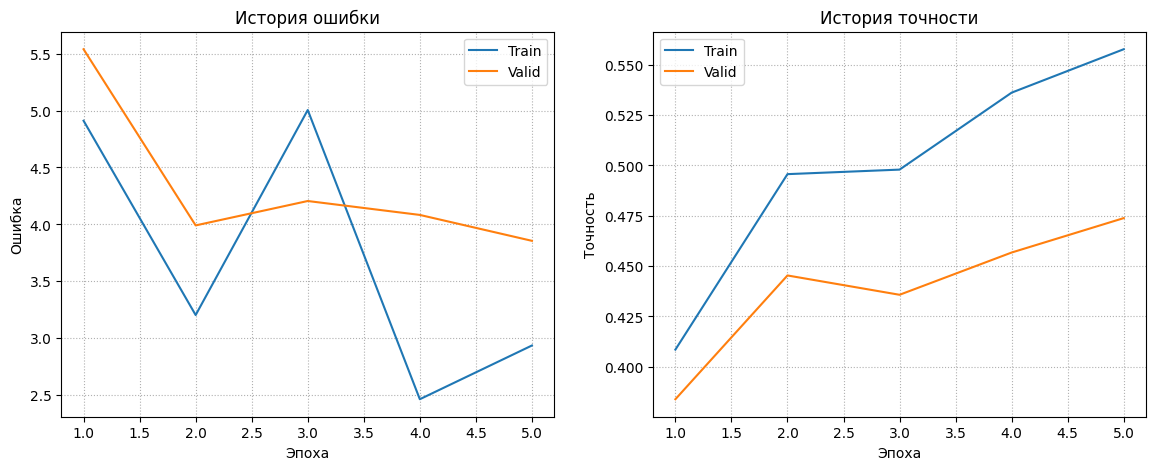


 Проверка качества

Ошибка на тесте: 3.8613
Точность на тесте: 0.4749


              precision    recall  f1-score   support

           0       0.51      0.59      0.55       107
           1       0.43      0.66      0.52        96
           2       0.45      0.25      0.32       100
           3       0.46      0.14      0.21        87
           4       0.49      0.36      0.42        91
           5       0.36      0.58      0.45       102
           6       0.49      0.58      0.53        91
           7       0.64      0.62      0.63       109
           8       0.59      0.67      0.63       104
           9       0.56      0.42      0.48       113

    accuracy                           0.49      1000
   macro avg       0.50      0.49      0.47      1000
weighted avg       0.50      0.49      0.48      1000



In [11]:
experiment(train_data, valid_data, model, epochs=5, lr=1e-3, optim="Adam")

Модель учится, все круто, берем ее за бейзлайн.

### Эксперимент 2 Построение нейронной сети с Sigmoid функцией активации

Реализуйте эксперимент, доработав соответсвующие модули Numpy_NN фреймворка. Количество слоев, функций на ваше усмотрение. Можно добавлять любые другие функции активации на ваше усмотрение, но указанная в эксперименте функция должна быть обязательно. Перед обучением проверьте с помощью utils.gradient_check градиент вашей модели.

In [10]:
np.random.seed(42)

model = Sequential(
    Linear(3072, 768),
    Sigmoid(),
    Linear(768, 10)
)

In [11]:
dataloader = Dataloader(train_data, batch_size=8)
x, y = next(iter(dataloader))
gradient_check(x, y, model)

2.579970930068282 2.58
Backprop is correct!


1.3474110202140633e-13


 Обучение модели

|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
|  1/5|  5.7754  | 0.3846  |  4.8970  | 0.3531  | 0.031375 |   79.2   |   79.3   |  
|  2/5|  4.2511  | 0.4327  |  4.4093  | 0.3852  | 0.027191 |   72.2   |  151.5   |  
|  3/5|  4.5367  | 0.4701  |  4.2765  | 0.4078  | 0.025153 |   70.4   |  221.8   |  
|  4/5|  3.5773  | 0.4792  |  4.2950  | 0.3969  | 0.020052 |   71.6   |  293.5   |  
|  5/5|  3.3042  | 0.5033  |  4.2658  | 0.4090  | 0.007087 |   70.3   |  363.8   |  

 Визуализация обучения



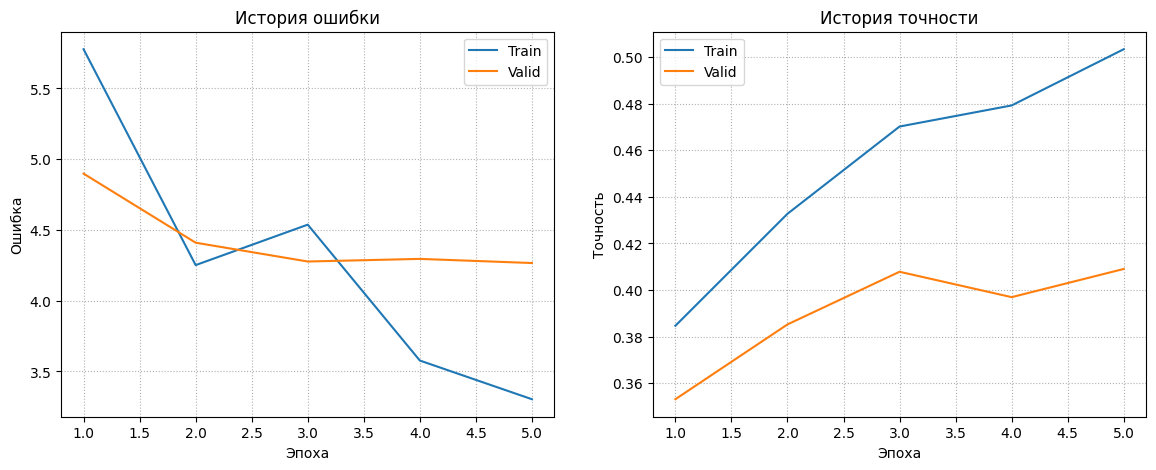


 Проверка качества

Ошибка на тесте: 4.2725
Точность на тесте: 0.4061


              precision    recall  f1-score   support

           0       0.43      0.62      0.51       107
           1       0.38      0.46      0.42        96
           2       0.26      0.24      0.25       100
           3       0.26      0.11      0.16        87
           4       0.37      0.34      0.35        91
           5       0.32      0.58      0.41       102
           6       0.52      0.40      0.45        91
           7       0.60      0.40      0.48       109
           8       0.52      0.54      0.53       104
           9       0.46      0.33      0.38       113

    accuracy                           0.41      1000
   macro avg       0.41      0.40      0.39      1000
weighted avg       0.42      0.41      0.40      1000



In [11]:
experiment(train_data, valid_data, model, epochs=5, lr=1e-3, optim="Adam")

Кажется, модель с сигмоидой учится медленнее, у меня нет возможности ее дообучить т.к. ноутбук еле тянет и зависает(
Но на том же количестве эпох результат у нее хуже

### Эксперимент 3 Построение нейронной сети с TanH функцией активации

Реализуйте эксперимент, доработав соответсвующие модули Numpy_NN фреймворка. Количество слоев, функций на ваше усмотрение. Можно добавлять любые другие функции активации на ваше усмотрение, но указанная в эксперименте функция должна быть обязательно. Перед обучением проверьте с помощью utils.gradient_check градиент вашей модели.

In [10]:
np.random.seed(42)

model = Sequential(
    Linear(3072, 768),
    Tanh(),
    Linear(768, 10)
)

In [11]:
dataloader = Dataloader(train_data, batch_size=8)
x, y = next(iter(dataloader))
gradient_check(x, y, model)

3.614208073698974 3.613
Backprop is correct!


2.485950387054524e-13


 Обучение модели

|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
|  1/5|  4.8086  | 0.3795  |  5.0469  | 0.3546  | 0.001551 |   77.2   |   77.2   |   
|  2/5|  5.1239  | 0.3922  |  4.9996  | 0.3511  | 0.001696 |   67.4   |  144.6   |  
|  3/5|  4.4249  | 0.4205  |  4.7739  | 0.3671  | 0.001111 |   68.5   |  213.1   |   
|  4/5|  4.1778  | 0.4235  |  4.8579  | 0.3638  | 0.001124 |   65.3   |  278.4   |  
|  5/5|  3.6162  | 0.4516  |  4.6555  | 0.3774  | 0.001361 |   62.8   |  341.2   |  

 Визуализация обучения



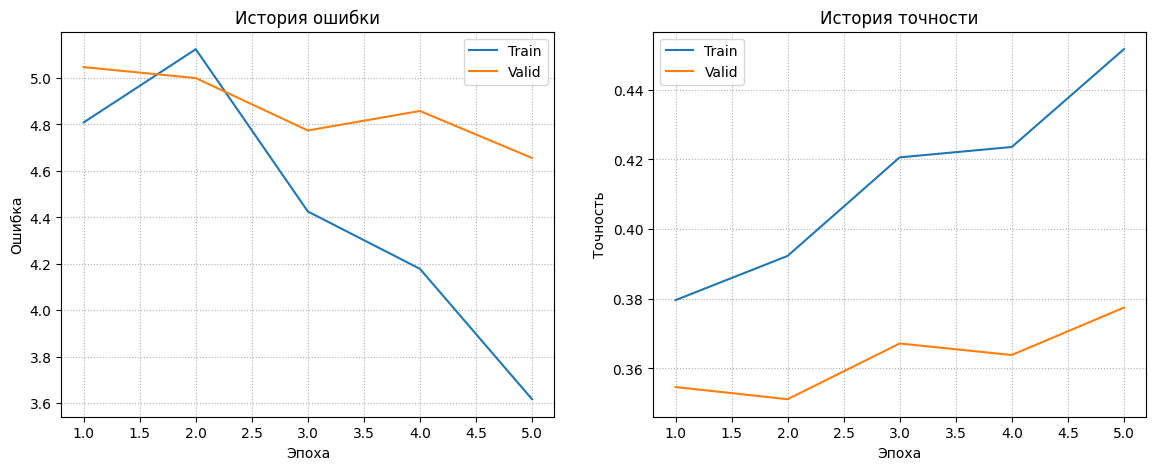


 Проверка качества

Ошибка на тесте: 4.5852
Точность на тесте: 0.3730


              precision    recall  f1-score   support

           0       0.31      0.36      0.33        14
           1       0.42      0.56      0.48         9
           2       0.38      0.33      0.35         9
           3       0.38      0.42      0.40        12
           4       0.00      0.00      0.00        11
           5       0.33      0.40      0.36        10
           6       0.11      0.20      0.14         5
           7       0.50      0.23      0.32        13
           8       0.31      0.31      0.31        13
           9       0.17      0.25      0.20         4

    accuracy                           0.31       100
   macro avg       0.29      0.31      0.29       100
weighted avg       0.31      0.31      0.30       100



In [12]:
experiment(train_data, valid_data, model, epochs=5, lr=1e-3, optim="Adam")

Модель с Tanh() учится еще медленне чем, с Sigmoid(), на том же количестве эпох она пока хуже всех

### Эксперимент 4 Построение нейронной сети с Dropout слоем

Реализуйте эксперимент, доработав соответсвующие модули Numpy_NN фреймворка. Количество слоев, функций на ваше усмотрение. Можно добавлять любые другие функции активации, слои на ваше усмотрение, но указанный в эксперименте слой должен быть обязательно. Перед обучением проверьте с помощью utils.gradient_check градиент вашей модели.  Подберите оптимальную вероятность в dropout.

In [10]:
np.random.seed(42)

model = Sequential(
    Linear(3072, 768),
    ReLU(),
    Dropout(0.1),
    Linear(768, 10)
)

In [11]:
dataloader = Dataloader(train_data, batch_size=8)
x, y = next(iter(dataloader))
gradient_check(x, y, model)

3.7624792358229504 3.762
Backprop is correct!


2.871891230139091e-13


 Обучение модели

|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
|  1/5|  3.8381  | 0.2948  |  6.4225  | 0.2908  | 0.001657 |   90.5   |   90.5   |   
|  2/5|  3.5042  | 0.3233  |  6.0743  | 0.3158  | 0.001780 |   83.9   |  174.4   |   
|  3/5|  2.9065  | 0.3367  |  5.7423  | 0.3198  | 0.001114 |   85.6   |  260.0   |   
|  4/5|  2.1848  | 0.3473  |  5.7963  | 0.3351  | 0.001221 |   84.0   |  344.0   |   
|  5/5|  2.7572  | 0.3600  |  5.6823  | 0.3380  | 0.001374 |   82.7   |  426.7   |   

 Визуализация обучения



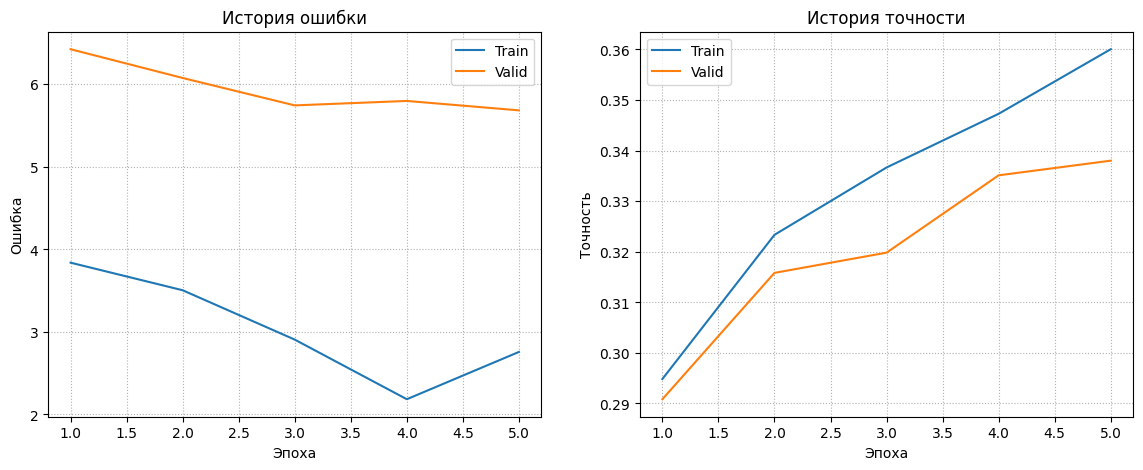


 Проверка качества

Ошибка на тесте: 5.7104
Точность на тесте: 0.3385


              precision    recall  f1-score   support

           0       0.62      0.71      0.67        14
           1       0.40      0.22      0.29         9
           2       1.00      0.11      0.20         9
           3       0.28      0.75      0.41        12
           4       0.20      0.36      0.26        11
           5       0.09      0.10      0.10        10
           6       0.00      0.00      0.00         5
           7       0.50      0.08      0.13        13
           8       0.50      0.23      0.32        13
           9       0.17      0.25      0.20         4

    accuracy                           0.32       100
   macro avg       0.38      0.28      0.26       100
weighted avg       0.42      0.32      0.29       100



In [12]:
experiment(train_data, valid_data, model, epochs=5, lr=1e-3, optim="Adam")

Dropout еще больше замедлил обучение, зато точность стала быстрее расти

### Эксперимент 5 Построение нейронной сети с Batchnorm слоем

Реализуйте эксперимент, доработав соответсвующие модули Numpy_NN фреймворка. Количество слоев, функций на ваше усмотрение. Можно добавлять любые другие функции активации, слои на ваше усмотрение, но указанный в эксперименте слой должен быть обязательно. Перед обучением проверьте с помощью utils.gradient_check градиент вашей модели.

In [10]:
np.random.seed(42)

model = Sequential(
    Linear(3072, 768),
    ReLU(),
    BatchNorm(768),
    Linear(768, 10)
)

In [11]:
dataloader = Dataloader(train_data, batch_size=8)
x, y = next(iter(dataloader))
gradient_check(x, y, model)

3.872983346207965 3.873
Backprop is correct!


2.343335929548949e-13


 Обучение модели

|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
|  1/5|  4.3155  | 0.4526  |  6.7048  | 0.4420  | 0.002566 |   88.0   |   88.0   |   
|  2/5|  3.5954  | 0.4969  |  6.4014  | 0.4720  | 0.001102 |   92.9   |  180.9   |   
|  3/5|  2.3009  | 0.5219  |  6.4978  | 0.4872  | 0.002096 |   80.5   |  261.3   |   
|  4/5|  2.6879  | 0.5429  |  6.5724  | 0.4879  | 0.001082 |   79.7   |  341.0   |   
|  5/5|  2.0932  | 0.5612  |  6.5719  | 0.4968  | 0.001957 |   79.2   |  420.2   |   

 Визуализация обучения



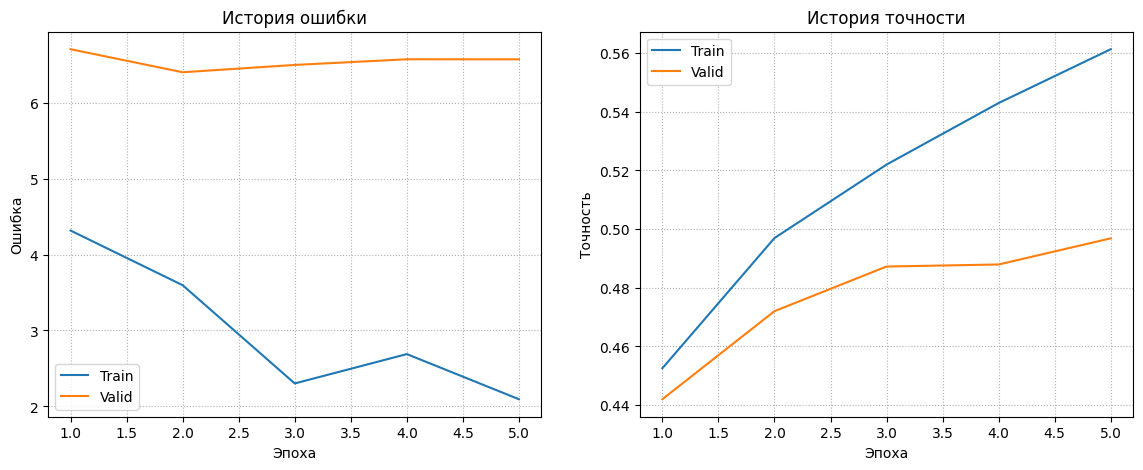


 Проверка качества

Ошибка на тесте: 6.4758
Точность на тесте: 0.4995


              precision    recall  f1-score   support

           0       0.64      0.50      0.56        14
           1       0.47      0.78      0.58         9
           2       0.50      0.11      0.18         9
           3       0.17      0.08      0.11        12
           4       0.25      0.18      0.21        11
           5       0.36      0.40      0.38        10
           6       0.13      0.40      0.20         5
           7       0.58      0.54      0.56        13
           8       0.57      0.62      0.59        13
           9       0.33      0.50      0.40         4

    accuracy                           0.41       100
   macro avg       0.40      0.41      0.38       100
weighted avg       0.43      0.41      0.40       100



In [12]:
experiment(train_data, valid_data, model, epochs=5, lr=1e-3, optim="Adam")

BatchNorm() - красавчик, качество поднял.

### Эксперимент 6 Эксперимент с Adam оптимизатором 

Обучите вашу нейронную сеть с Adam оптимизатором. Подбор гиперпараметров на ваше усмотрение. Перед обучением проверьте с помощью utils.gradient_check градиент вашей модели.

Выше я уже обучала все модели с оптимизатором Adam, так что обучим модель из первого эксперимента с GD и сравним

In [13]:
np.random.seed(42)

model = Sequential(
    Linear(3072, 768),
    ReLU(),
    Linear(768, 10)
)

In [14]:
dataloader = Dataloader(train_data, batch_size=8)
x, y = next(iter(dataloader))
gradient_check(x, y, model)

1.9202864369675332 1.92
Backprop is correct!


2.622625003312464e-13


 Обучение модели

|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
|  1/5|  4.7181  | 0.4108  |  4.3214  | 0.3906  | 0.008760 |   52.4   |   52.4   |   
|  2/5|  4.4313  | 0.4530  |  3.9926  | 0.4200  | 0.004568 |   48.4   |  100.8   |  
|  3/5|  2.9245  | 0.4836  |  3.7842  | 0.4398  | 0.002922 |   50.3   |  151.1   |   
|  4/5|  2.9689  | 0.5032  |  3.6620  | 0.4466  | 0.002184 |   49.3   |  200.3   |  
|  5/5|  3.0843  | 0.5240  |  3.5822  | 0.4558  | 0.003236 |   47.4   |  247.7   |  

 Визуализация обучения



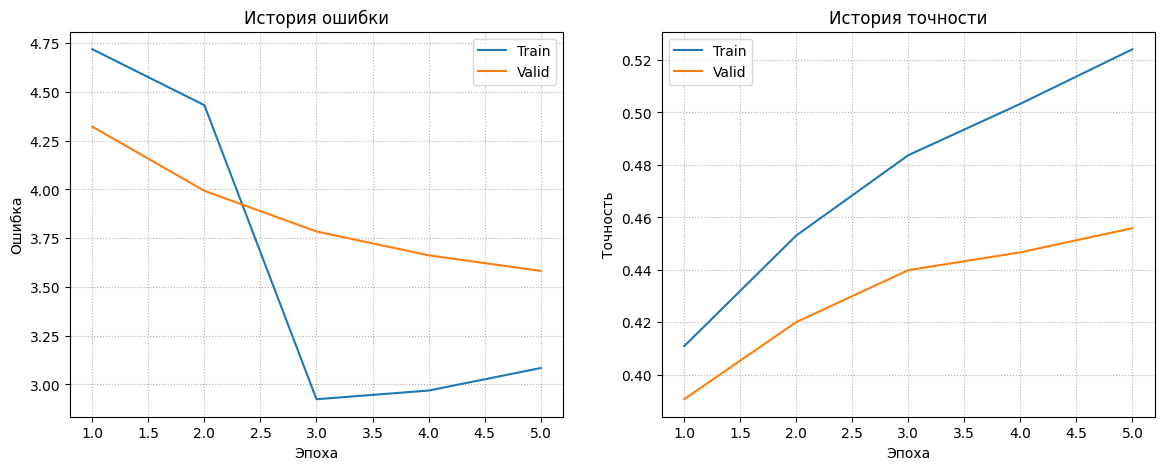


 Проверка качества

Ошибка на тесте: 3.5368
Точность на тесте: 0.4597


              precision    recall  f1-score   support

           0       0.42      0.57      0.48        14
           1       0.40      0.44      0.42         9
           2       0.29      0.22      0.25         9
           3       0.41      0.58      0.48        12
           4       0.38      0.27      0.32        11
           5       0.27      0.30      0.29        10
           6       0.25      0.40      0.31         5
           7       0.60      0.23      0.33        13
           8       0.44      0.31      0.36        13
           9       0.33      0.50      0.40         4

    accuracy                           0.38       100
   macro avg       0.38      0.38      0.36       100
weighted avg       0.40      0.38      0.37       100



In [15]:
experiment(train_data, valid_data, model, epochs=5, lr=1e-3, optim="GD")

Здесь сильной разницы между оптимизаторами не видно, т.к. мало эпох, на дистанции адам сходится быстрее

### Эксперимент 7 Эксперимент c количеством слоев

Зафиксируйте модель и начинайте добавлять слои. Как меняется качество модели?

Будем отталкиваться от бейзлайна:

Sequential(
    Linear(3072, 768),
    ReLU(),
    Linear(768, 10)
)

In [21]:
np.random.seed(42)

model = Sequential(
    Linear(3072, 512),
    ReLU(),
    Linear(512, 128),
    ReLU(),
    Linear(128, 10),
)

In [22]:
dataloader = Dataloader(train_data, batch_size=8)
x, y = next(iter(dataloader))
gradient_check(x, y, model)

2.468552207265766 2.469
Backprop is correct!


3.5204346383538527e-13


 Обучение модели

|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
|  1/5|  4.5133  | 0.3991  |  4.1901  | 0.3804  | 0.001147 |   59.9   |   59.9   |  
|  2/5|  3.9727  | 0.4753  |  3.6477  | 0.4438  | 0.001064 |   53.3   |  113.2   |  
|  3/5|  3.3813  | 0.4950  |  3.5381  | 0.4528  | 0.000982 |   52.7   |  165.9   |  
|  4/5|  2.8121  | 0.5279  |  3.3902  | 0.4713  | 0.000974 |   53.6   |  219.5   |  
|  5/5|  3.0302  | 0.5561  |  3.2657  | 0.4838  | 0.000809 |   51.8   |  271.4   |  

 Визуализация обучения



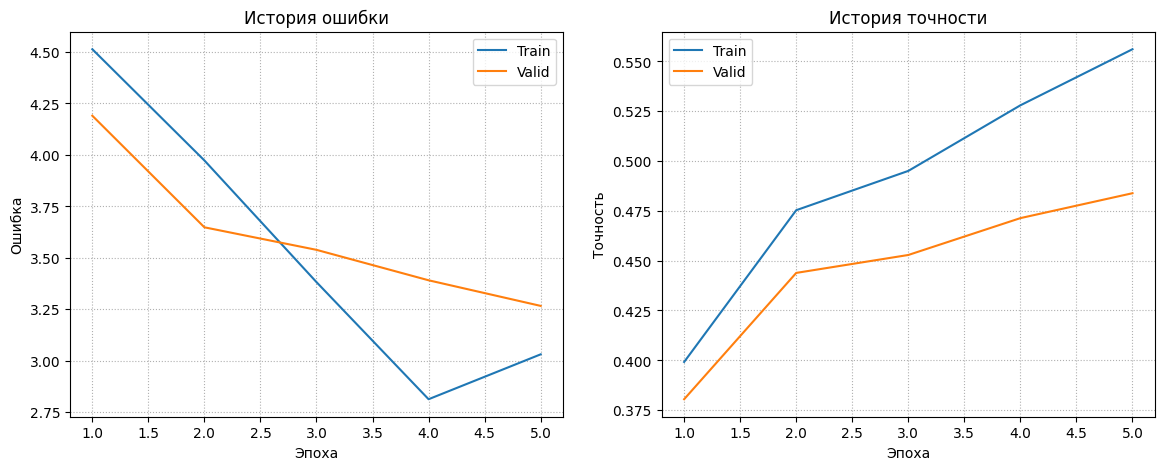


 Проверка качества

Ошибка на тесте: 3.2399
Точность на тесте: 0.4816


              precision    recall  f1-score   support

           0       0.47      0.50      0.48        14
           1       0.50      0.56      0.53         9
           2       0.25      0.33      0.29         9
           3       0.20      0.08      0.12        12
           4       0.40      0.18      0.25        11
           5       0.25      0.30      0.27        10
           6       0.12      0.20      0.15         5
           7       0.75      0.69      0.72        13
           8       0.60      0.46      0.52        13
           9       0.36      1.00      0.53         4

    accuracy                           0.41       100
   macro avg       0.39      0.43      0.39       100
weighted avg       0.42      0.41      0.40       100



In [23]:
experiment(train_data, valid_data, model, epochs=5, lr=1e-3, optim="Adam")

Пока теория подтверждается - увеличение слоев дало увеличение качества

### Эксперимент 8 Эксперимент c количеством нейронов

Зафиксируйте модель и увеличьте количетсво весов в одном из слоев. Дает ли это прирост качества?

Уменьшим кол-во нейронов в скрытом слое последней модели из эксперимента 7

In [24]:
np.random.seed(42)

model = Sequential(
    Linear(3072, 512),
    ReLU(),
    Linear(512, 16),
    ReLU(),
    Linear(16, 10),
)

In [25]:
dataloader = Dataloader(train_data, batch_size=8)
x, y = next(iter(dataloader))
gradient_check(x, y, model)

2.3385358667335803 2.338
Backprop is correct!


4.722420493570471e-13


 Обучение модели

|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
|  1/5|  6.1459  | 0.2542  |  5.8896  | 0.2508  | 0.000743 |   59.1   |   59.1   |  
|  2/5|  4.9636  | 0.3436  |  4.8119  | 0.3387  | 0.000486 |   51.7   |  110.8   |  
|  3/5|  4.5135  | 0.3867  |  4.3782  | 0.3633  | 0.000556 |   53.1   |  163.9   |  
|  4/5|  3.1630  | 0.4277  |  4.0956  | 0.3978  | 0.000610 |   52.2   |  216.1   |  
|  5/5|  3.3058  | 0.4567  |  3.8486  | 0.4178  | 0.000694 |   52.7   |  268.8   |  

 Визуализация обучения



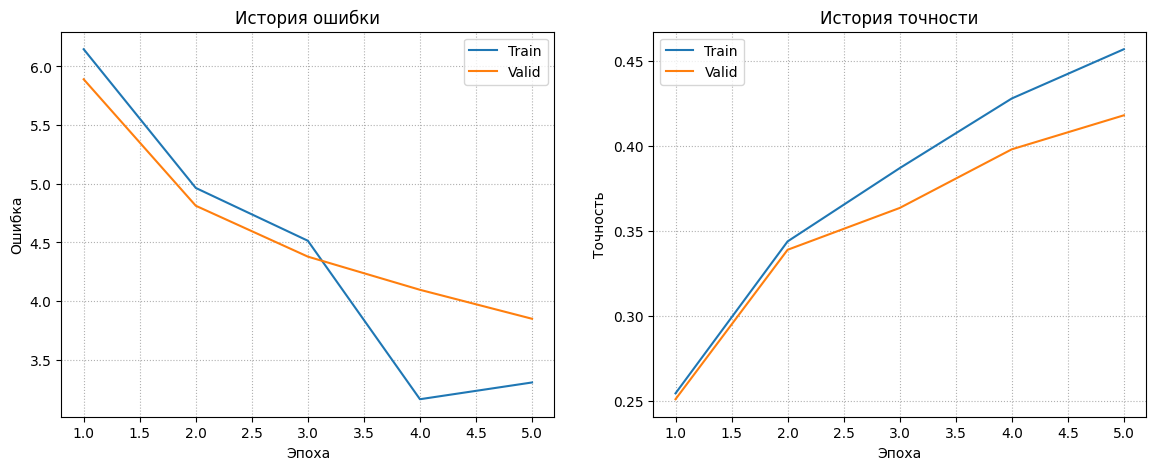


 Проверка качества

Ошибка на тесте: 3.8261
Точность на тесте: 0.4300


              precision    recall  f1-score   support

           0       0.42      0.57      0.48        14
           1       0.57      0.89      0.70         9
           2       0.00      0.00      0.00         9
           3       0.50      0.33      0.40        12
           4       0.43      0.27      0.33        11
           5       0.57      0.40      0.47        10
           6       0.07      0.20      0.11         5
           7       0.73      0.62      0.67        13
           8       0.44      0.31      0.36        13
           9       0.67      0.50      0.57         4

    accuracy                           0.42       100
   macro avg       0.44      0.41      0.41       100
weighted avg       0.46      0.42      0.42       100



In [26]:
experiment(train_data, valid_data, model, epochs=5, lr=1e-3, optim="Adam")

как и ожидалось качество немного понизилось

### Эксперимент 9 Эксперимент c размером батча

Зафиксируйте модель и обучитесь на разных размерах. Как размер батча влияет на процесс обучения?

In [28]:
np.random.seed(42)

model = Sequential(
    Linear(3072, 128),
    Tanh(),
    Linear(128, 10)
)

In [29]:
dataloader = Dataloader(train_data, batch_size=8)
x, y = next(iter(dataloader))
gradient_check(x, y, model)

3.0516389039340264 3.05
Backprop is correct!


3.270096262627405e-13


 Обучение модели

|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
|  1/5|  5.1998  | 0.3528  |  5.0058  | 0.3308  | 0.000842 |   20.9   |   20.9   |  
|  2/5|  5.5311  | 0.3812  |  4.7489  | 0.3642  | 0.000701 |   20.2   |   41.1   |  
|  3/5|  4.7349  | 0.4009  |  4.5676  | 0.3711  | 0.000786 |   19.6   |   60.7   |  
|  4/5|  3.9832  | 0.4094  |  4.5599  | 0.3755  | 0.000655 |   19.6   |   80.3   |  
|  5/5|  4.5005  | 0.4138  |  4.4958  | 0.3789  | 0.000773 |   21.0   |  101.3   |  

 Визуализация обучения



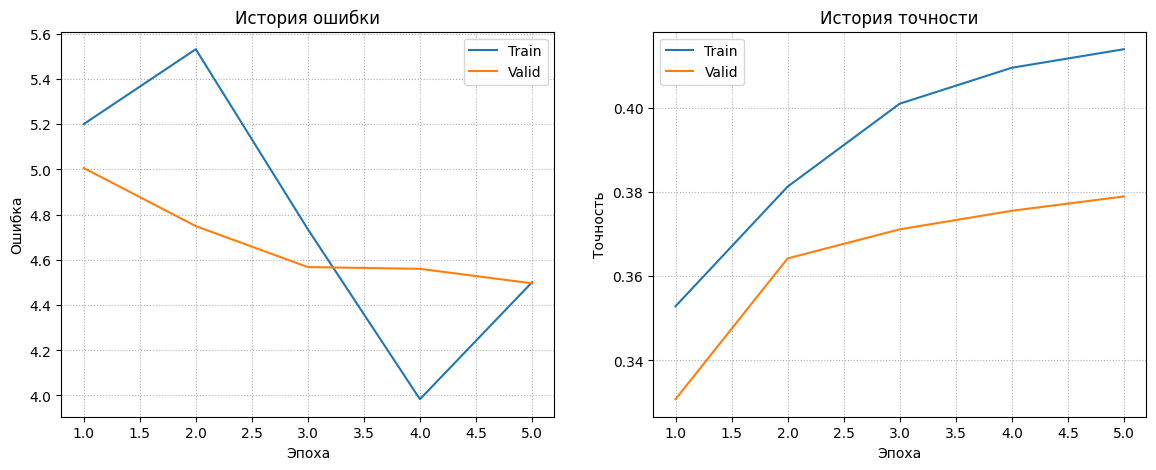


 Проверка качества

Ошибка на тесте: 4.4821
Точность на тесте: 0.3844


              precision    recall  f1-score   support

           0       0.33      0.21      0.26        14
           1       0.38      0.56      0.45         9
           2       0.43      0.33      0.38         9
           3       0.56      0.42      0.48        12
           4       0.27      0.27      0.27        11
           5       0.43      0.30      0.35        10
           6       0.14      0.40      0.21         5
           7       0.83      0.38      0.53        13
           8       0.36      0.31      0.33        13
           9       0.15      0.50      0.24         4

    accuracy                           0.35       100
   macro avg       0.39      0.37      0.35       100
weighted avg       0.43      0.35      0.37       100



In [31]:
# batch_size=100
experiment(train_data, valid_data, model, epochs=5, lr=1e-3, optim="Adam")


 Обучение модели

|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
|  1/5|  5.8806  | 0.3541  |  4.9373  | 0.3426  | 0.002678 |   87.0   |   87.0   |    
|  2/5|  6.9045  | 0.3640  |  4.8245  | 0.3551  | 0.002789 |   86.1   |  173.0   |    
|  3/5|  5.2800  | 0.3701  |  4.8039  | 0.3531  | 0.002469 |   84.8   |  257.9   |    
|  4/5|  4.1395  | 0.3695  |  4.8071  | 0.3551  | 0.002331 |   84.8   |  342.6   |    
|  5/5|  3.4723  | 0.3834  |  4.7357  | 0.3654  | 0.002199 |   86.4   |  429.1   |    

 Визуализация обучения



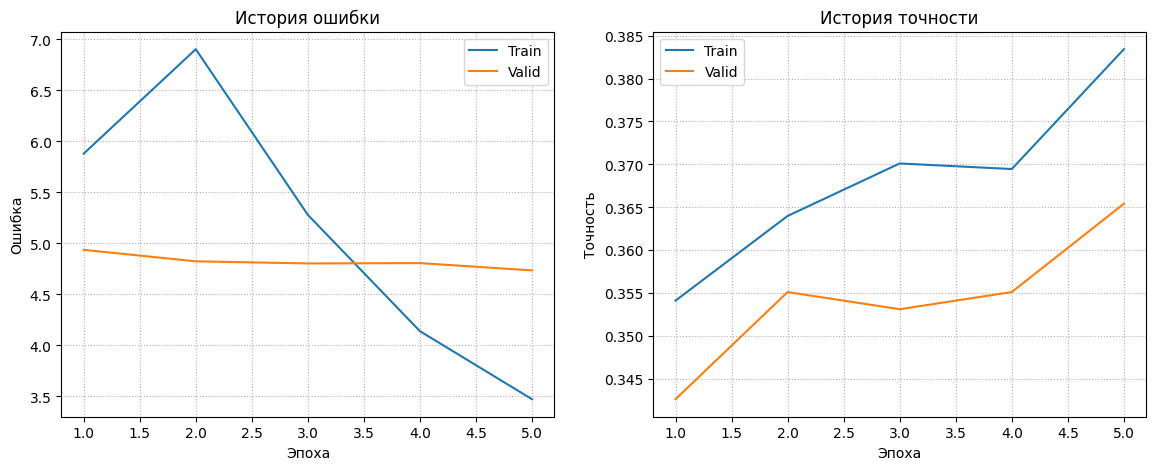


 Проверка качества

Ошибка на тесте: 4.6535
Точность на тесте: 0.3638


              precision    recall  f1-score   support

           0       0.31      0.36      0.33        14
           1       0.38      0.56      0.45         9
           2       0.38      0.33      0.35         9
           3       0.43      0.25      0.32        12
           4       0.20      0.18      0.19        11
           5       0.20      0.20      0.20        10
           6       0.22      0.40      0.29         5
           7       0.50      0.31      0.38        13
           8       0.27      0.23      0.25        13
           9       0.25      0.50      0.33         4

    accuracy                           0.31       100
   macro avg       0.31      0.33      0.31       100
weighted avg       0.33      0.31      0.31       100



In [32]:
# batch_size=10
experiment(train_data, valid_data, model, epochs=5, batch_size=10, lr=1e-3, optim="Adam")

При меньшем размере батча некоторые классы стали определяться хуже, что логично, поэтому средняя точность стала ниже. Но сходится модель получше

### Эксперимент 10 Эксперимент с регуляризацией

Добавьте в процесс обучения L1/L2 регуляризацию. Повлияло ли это на качесвто? Выведите норму весов без регуляризации и с.

На это у меня уже не хватает сил, регуляризация по идее от переобучения спасает, а мой ноут еле как 5 эпох вытягивает, больше - слишком долго ждать и на этот эффект переобучения я пока не могу посмотреть(

### Эксперимент 11 Финальная архитектура

Как выглядит ваша финальная модель?

Пока что никак(